In [43]:
%ls results/

deeplabv3resnet.pt       loss_deeplabv3resnet.pt  preds.pt


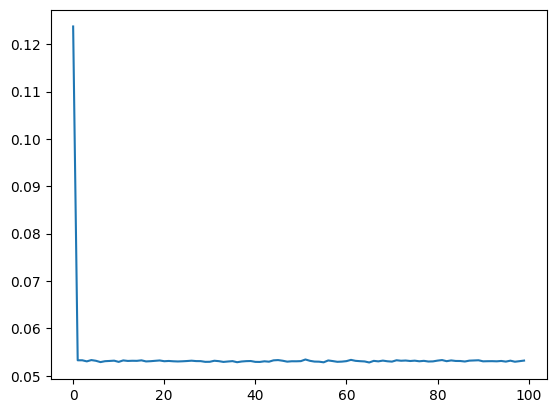

In [39]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torch.nn as nn
from deeplabv3resnet import DataSet_with_transform, preprocess, postprocess, MulticlassDiceLoss
from torch.utils.data import DataLoader, Dataset
from torchmetrics.clustering import AdjustedRandScore as adjusted_rand_score
import numpy as np
import os



data_dir = os.getcwd() + '/data'
y_valid = torch.load(data_dir+'/y_valid.pt')
x_valid = torch.load(data_dir+'/x_valid.pt')

num_classes = 31
in_channels = 256
batch_size = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the model

model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # on modifie la première couche pour prendre du greyscale
model.classifier[4] = DeepLabHead(in_channels, num_classes) 
model.load_state_dict(torch.load('./results/deeplabv3resnet.pt', map_location='cpu'))
model.to(device)


# Load data

y_valid = torch.load(data_dir+'/y_valid.pt')
x_valid = torch.load(data_dir+'/x_valid.pt')
print(y_valid.sum())
valid_dataset = DataSet_with_transform(x_valid, y_valid, transform=preprocess)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


# Define accuracy function

def rand_index(y_true, y_pred) -> float: 
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    metric = adjusted_rand_score()
    for img_index in range(y_true.shape[0]):
        labels = y_true[img_index, :, :].flatten()
        preds = y_pred[img_index, :, :].flatten()
        individual_rand_index.append(metric(labels, preds))
    return torch.mean(torch.tensor(individual_rand_index))


# Make predictions

loss_f = MulticlassDiceLoss(num_classes=num_classes)
model.eval()
predictions = []
batch_loss = []
accuracies = []
for x, y in valid_dataloader:
    x, y = x.to(device), y.to(device)
    outputs = postprocess(model(x)['out'].softmax(dim=1)) 
    print(outputs.shape)
    print(y.shape)

    loss = loss_f(outputs, y)
    print(loss)
    preds = outputs.argmax(axis = 1)
    print(y)
    acc = rand_index(y, preds)

    batch_loss.append(loss.detach())
    accuracies.append(acc.detach())
    predictions.append(preds.detach())
    break


#Results

mean_loss = torch.mean(torch.tensor(batch_loss))
mean_accuracy = torch.mean(torch.tensor(accuracies))


print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

torch.save(preds, "results/preds.pt")


tensor(0)


KeyboardInterrupt: 

In [48]:
import matplotlib.pyplot as plt
preds = torch.load('preds.pt', map_location='cpu')
preds = torch.cat(preds)
preds.sum()

tensor(0)

In [36]:
y_valid[0].sum()

tensor(0)